# Individual Project Submission for ENG5337
Due date: 28th February 2025

Artificial Intelligence (AI) and Machine Learning (ML) are revolutionizing the field of robotics. This project aims to provide hands-on experience in developing and evaluating AI/ML algorithms for a line-following robot using the Quanser Qbot simulated environment. In this project, students will consider the requirements for deploying AI/ML algorithms in a robotics environment and how to measure their performance.

## Instructions

Students should complete each section of this notbook. Notes:
* Text enclosed in """triple quotes""" should be replaced with the students own text.
* The Python functions should be developed to integrate with the Quanser Python scripts. As such, they may need adjusted to run independently in this notebook. An example of this is shown in task A4.
* In Section B2, plots should be embedded in the notebook as images - syntax for doing this is included below. Please remember to upload the relevant image files along with your submission. Failure to do so will result in loss of marks.

Hello there son

## Part A: Collecting Labelled Training Data

### Input Data Choice


### A1. Input Data Choice
The downward facing camera is most suitable as the lines the robot follows are below it. 
Combination with LIDAR could allow the walls of the theatre to be used as reference points. LIDAR on the QBot detects in a 360 degree radius, giving angles and distances for objects relative to the robot. When used in conjunction with the Gyroscope, this could allow the QBot to work out its exact position relative to a specific cardinal direction, such as north. However, for the purposes of this task, the most efficient method would be using only the Downward Facing Camera. The downwards facing camera allows the robot to track the specific path its supposed to be following by checking whether or not the path is straight, left, right, or at a crossroads. This alone would be enough to ensure the robot stays on the line. When used in combination with the gyroscope, the robot could determine its optimal cardinal direction and use that to navigate crossroads. 

### A2. Data Pre-processing and Filtering
Thresholding is the first pre-processing technique used to prepare the data. Done inside the vision.subselect_and_threshold function, relevent features are extracted by converting the image into binary, and selecting a maximum and minimum intensity value. This ensures that noise is also reduced as thresholding can be done to ensure that the line and only the line is visible, making sure that features such as noise are not treated as a followable line-path.

The second techniue is segmentation. Segmentation is used inside the vision.image_find_objects method and returns blobs that fit the critereon for a line that could be followed. This allows allows the robot to track specific paths by recognising the white lines, allowing it to follow the line once the image has been thresholded to ensure that the robot does not chase after camera noise.

### A3. Labelling Structure
Data would likely be split into 5 sets: Straight, Left, Right, Crossroads, No-line.

- Straight paths indicate that the robot needs to move straight forward.
- If the line is on the left, the robot will have to turn left
- Similarly, if the line is on the right, the robot will have to turn right
- At a crossroads, the robot will have to make a decision as to which direction to take, as lines will be left, right and straight forward
- Finally, if there are no lines, the robot is off track and should try and find a line to follow again

These labels should cover every possible outcome for the downward facing camera, and so desicions will be made for each of these. Classification will be down based on thee position of the line. If the error between the line and the centre is between -25 and 25, the line will be considered Straight. Likewise, if the error is greater than 25, it will be determined to be a right turn and should it be less than -25, it will be labelled as a left turn.


Experimentation will be done into how the robot reacts to crossroads once the model is implimented. For now, crossroads have not been added to the training data as it going straight forward is a valid decision at crossroads but for different routes with more specific paths, crossroads may indicate that the robot should turn left, for example.

### A4. Function to Collect, Label, and Store Training Data

Copy and paste the python function you have written to collect, label and store training data for the line follwoing task in the following cell.

In [1]:
from datetime import datetime
import random
import time
import numpy as np
import os
import cv2
from PIL import Image
import pandas as pd

from pal.products.qbot_platform import QBotPlatformCSICamera
from qbot_platform_functions import QBPVision

DATA_DIR = "training_data"
CSV_PATH = os.path.join(DATA_DIR, "training_data.csv")
os.makedirs(DATA_DIR, exist_ok=True)

LABELS = ["straight", "left", "right", "off_line"]
os.makedirs(DATA_DIR, exist_ok=True)
for label in LABELS:
    os.makedirs(os.path.join(DATA_DIR, label), exist_ok=True)

def add_entry(image, label, error):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    img_filename = f"{DATA_DIR}/{label}/img_{timestamp}.jpg"
    cv2.imwrite(img_filename, image)
    df = pd.DataFrame([[img_filename, label, error]], columns=["image_path", "label", "error"])
    df.to_csv(CSV_PATH, mode='a', header=False, index=False)

def collect_and_label_data(input):
    # Your code here
    vision = QBPVision()
        
    # Classificaiton
    binary = vision.subselect_and_threshold(input, 50, 100, 225, 255) # Replace input with camera image for camera data
    col, row, area = vision.image_find_objects(binary, 8, 500, 2000)
    if col is None:
        error = None
        label = "off_line"
        add_entry(binary, label, error)
    else:
        error = col - 160

        if -25 <= error <= 25: # Straight Line
            label = "straight"
            add_entry(binary, label, error)
        elif -200 < error < -25: # Left Turn
            label = "left"
            add_entry(binary, label, error)
        elif 200 > error > 25: # Right Turn
            label = "right"
            add_entry(binary, label, error)

# Insert test run of function HERE (see next cell for an example of how this might be achieved)

def create_mock_input(bottom_x, top_x):
    mock_image = np.zeros((200, 320), dtype=np.uint8)
    cv2.line(mock_image, (top_x, 0), (bottom_x, 200), (255), 25)
    return mock_image

# Mock Data, to get real data could use camera_image
for i in range(20):
    x = random.randint(-60,380) # Out of bounds to simulate off line
    x_offset = random.randint(-50,50) # Offset ensures not too steep turns for consistency with line
    time.sleep(1)
    collect_and_label_data(create_mock_input(x,x+x_offset))

Make sure the function can run within this notebook. Below is an example of how this might be achieved by generating some artificial input data

In [ ]:
import numpy as np
import os
import cv2
from PIL import Image

def save_data_example(image, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save binary image
    image_filename = os.path.join(output_dir, "image.png")
    cv2.imwrite(image_filename, image)

# To run this function, we create dummy arguments

# Create 50 x 320 array with entries of 0 and 1 randomly distributed
array = np.random.randint(2, size=(50, 320))
output_dir = r"test_project"

# Test run of function
# save_data_example(array, output_dir)

## Part B: Performance Metrics


### B1. Performance Metrics Functions
In the following cell copy and paste the python function(s) you have written to measure the accuracy of the Quanser QBot in its line following task.

In [2]:
# Code from Individual Project
DATA_DIR = "error_data"
CSV_PATH = os.path.join(DATA_DIR, "error_data.csv")
os.makedirs(DATA_DIR, exist_ok=True)

def add_error_metric(error):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    df = pd.DataFrame([[timestamp, error]], columns=["timestamp", "error"])
    df.to_csv(CSV_PATH, mode='a', header=False, index=False)

def determine_error(input):
    # Your code here
    vision = QBPVision()
        
    # Classificaiton
    binary = vision.subselect_and_threshold(input, 99, 101, 225, 255) # Replace input with camera image for camera data
    col, row, area = vision.image_find_objects(binary, 8, 5, 200)
    if col is None:  # Handle the case when no objects are found
        error = 160
    else:
        error = abs(col - 160) # Maximum error = 160
    return error

def get_robot_image():
    vision = QBPVision()
    frameRate, sampleRate = 60.0, 1/60.0
    downCam = QBotPlatformCSICamera(frameRate=frameRate, exposure = 39.0, gain=17.0)
    undistorted = vision.df_camera_undistort(downCam.imageData)
    camera_image = cv2.resize(undistorted, (320, 200))
    return camera_image

def analyse_robot_image(image):
    add_error_metric(determine_error(image))

NameError: name 'os' is not defined

### B2. Deployment of Performance Metrics Functions
In the project descriptor, you were asked to measure accuracy of the line follower, that is how much the robot deviates from its intended path. The output of this function should be a plot which represents how the robot deviates from the line. For example, in the case of the down-cam sensor, you could calculate the distance of the centre of the robot from the centre of the white line (y-axis) in each frame (x-axis). Please enter the resulting plot (based on the performance of the standard line-following script provided in the Quanser Mobile Robotics downloads) in the cell below. Note to embed images in a Jupyter notebook you can use the following syntax (this will be explicitly visible in markdown mode):<img src="test1.jpg" alt="Test Image" width="300"/>

Remember to upload the image files along with your submission on Moodle! Failing to do so will result in loss of marks for this section!

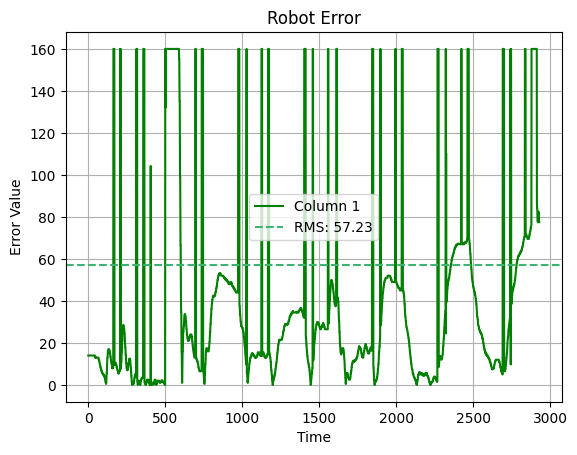

In [10]:
import matplotlib.pyplot as plt

def plot_error_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    column_data = df.iloc[:, 1]
    rms = np.sqrt(np.mean(column_data**2))
    
    plt.plot(df.iloc[:, 1], color = 'g', linestyle='-', label='Column 1')
    plt.axhline(y=rms, color='mediumseagreen', linestyle='--', label=f'RMS: {rms:.2f}')
    plt.xlabel('Time')
    plt.ylabel('Error Value')
    plt.title('Robot Error')
    plt.legend()
    plt.grid()
    plt.show()

plot_error_from_csv('error_data/error_data.csv')

The error can be seen by running the above code with the error_data provided from driving the robot automatically using the code from the previous labs. The absolute of the error was taken for this to account for both left and right errors, focussing primariy on deviation from the centre without regard to direction. The root mean squared was also provided to show the average error for the robot's path, useful when comparing how the robot does in comparison to other models when eventually this is used as part of the group project.

![Error plot](error_plot.png)